# Neural Network

In [12]:
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [20]:
input_file = "testinput10A.txt"
output_file = "testOutput10A.txt"
f_in = np.array([line.rstrip('\n').split(',') for line in open(input_file, 'r')])  
X = []
Z = []
C = []
CZ = []

read_classification = False
for data in f_in:
    if(read_classification):
        C.append((float(data[0]), float(data[1])))
    else:
        if(data[0] == '0' and data[1] == '0'):
            read_classification = True
        else:
            X.append((float(data[0]), float(data[1])))
            Z.append((float(data[2], )))
            
f_out = np.array([line.rstrip('\n') for line in open(output_file, 'r')])
for data in f_out:
    CZ.append(float(data))
    
X = np.array(X)
Z = np.array([Z]).T
C = np.array(C)
CZ = np.array([CZ]).T

## Normalization

In [21]:
def normalize(X, C):
    # zero mean
    # print(X, C)
    means = []
    for column in np.concatenate((X, C), axis=0).T:
        means.append(np.mean(column))
        
    X -= means
    C -= means
    #print(means)
    #print(X, C)
    
    # from -1 to 1
    norms = []
    for column in np.concatenate((X, C), axis=0).T:
        min_ = abs(np.amin(column))
        max_ = abs(np.amax(column))
        norms.append(max(min_, max_))
    #print(norms)
    #print(X/norms, C/norms)
    return X / norms, C / norms
    
X, C = normalize(X, C)

## Paint Data

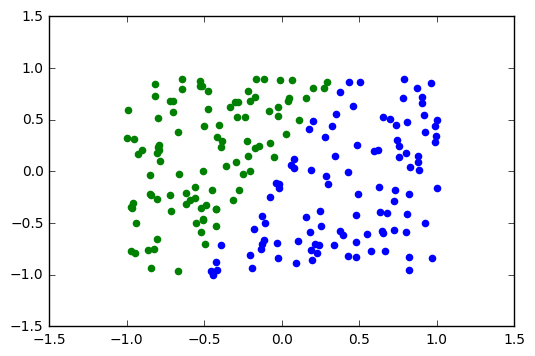

In [22]:
plt.figure()
i = 0
for z in Z:
    if z[0] > 0:
        plt.scatter(X.T[0, i], X.T[1, i], color="green")
    else:
        plt.scatter(X.T[0, i], X.T[1, i], color="blue")
        
    i += 1

## Activation Functions

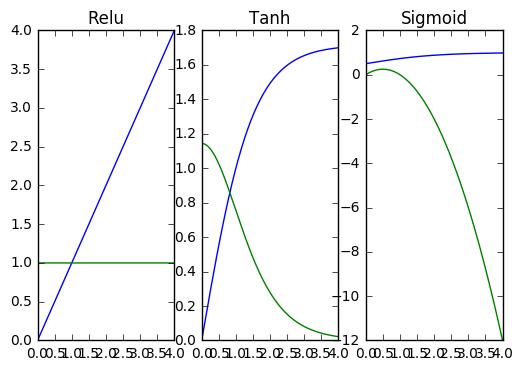

In [23]:
def relu(X, derived=False):
    if(derived):
        return 1.0 * np.greater(X, 0)
    else:
        return np.maximum(X, 0, X)
    
def tanh(X, derived=False):
    if(derived):
        return 1.1439* (1 - np.square(np.tanh((2/3) * X)))
    else:
        return 1.7159 * np.tanh((2/3) * X)
    
def sigmoid(X, derived=False):
    if(derived):
        return X * ( 1 - X)
    else:
        return (1 / (1 + np.exp(-(X))))

plt.figure()
AX = np.linspace(-4, 4, 10000)
p1 = plt.subplot(1, 3, 1)
p1.plot(AX, relu(AX, False), label="Relu")
p1.plot(AX, relu(AX, True), label="Relu'")
p1.set_title("Relu")

p2 = plt.subplot(1, 3, 2)
p2.plot(AX, tanh(AX, False), label="Tanh")
p2.plot(AX, tanh(AX, True), label="Tanh'")
p2.set_title("Tanh")

p3 = plt.subplot(1, 3, 3)
p3.plot(AX, sigmoid(AX, False), label="Sigmoid")
p3.plot(AX, sigmoid(AX, True), label="Sigmoid'")
p3.set_title("Sigmoid")

In [ ]:
## Network Class

In [88]:
class NeuralNetwork:
    def __init__(self, hidden_layers=1, neurons=[3, 4 ,1], activation_function=tanh, learning_rate=0.01, momentum=0):
        assert(len(neurons) == hidden_layers + 2)
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weights = [2 * np.random.random((neurons[i],neurons[i+1])) - 1 for i in range(0, hidden_layers + 1)]
        #print("weights:", self.weights)
        self.outputs = [np.zeros(neurons[i]) for i in range(0, hidden_layers + 2)]
        self.deltas = [np.zeros(neurons[i]) for i in range(0, hidden_layers + 2)]
        self.t_error = []
        self.error = []
        self.best_weights = []
        self.best_error = np.inf
        
    def train(self, X, Z, split=0.67, epochs=20000):
        X = self.__append_bias(X)
        self.t_error = []
        self.error = []
        self.update = [0 for i in range(0, self.hidden_layers + 1)]
        self.last_update = self.update
        XT, ZT, XV, ZV = self.__split(X, Z, split)
        for i in range(epochs):
            self.__shuffle(XT, ZT)
            #print("data:\n", XT)
            #print("target:\n", ZT)            
            self.__forward(XT)
            #print("l1:\n", self.outputs[1])
            #print("l2:\n", self.outputs[2])
            self.__backwards(ZT)
            self.__update_weights()
            self.__error(XV, ZV)
            self.__save_weights()
            #if(i % (epochs/10) == 0):
                #print("VE:", self.error[-1])
                #print("TE:", self.t_error[-1])
            
            if(self.error[-1] <= 0.0001):
                break
            elif(len(self.error) > 2 and self.error[-2] <= self.error[-1]):
                break
        
        self.__restore_weights()
        
        
    def __append_bias(self, X):
        X_ = np.ones((X.shape[0], X.shape[1] + 1))
        X_[:,:-1] = X
        return X_
        
    def __shuffle(self, X, Z):
        ids = list(range(len(X)))
        np.random.shuffle(ids)
        return np.asarray([X[id, :] for id in ids]), np.asarray([Z[id] for id in ids])
    
    def __split(self, X, Z, split):
        X, Z = self.__shuffle(X, Z)
        s = int(len(X) * split)
        return X[:s], Z[:s], X[s:], Z[s:]

    def __forward(self, X):
        self.outputs[0] = X
        for i in range(0, self.hidden_layers + 1):            
            self.outputs[i + 1] = self.activation_function(np.dot(self.outputs[i], self.weights[i]))
    
    def __backwards(self, Z):
        self.deltas[self.hidden_layers + 1] = (Z - self.outputs[self.hidden_layers + 1]) * self.activation_function(self.outputs[self.hidden_layers + 1], True)
        #print("l2_error:\n", (Z - self.outputs[self.hidden_layers + 1]))
        self.t_error.append(np.mean(np.abs(Z - self.outputs[self.hidden_layers + 1])))
        #print("l2_delta:\n", self.deltas[self.hidden_layers + 1])
        for i in reversed(range(1, self.hidden_layers + 1)): # not for layer 0
            self.deltas[i] = self.deltas[i+1].dot(self.weights[i].T) * self.activation_function(self.outputs[i], True)
            #print("l1_delta:\n", self.deltas[i])
       
            
    def __update_weights(self):
        for i in reversed(range(0, self.hidden_layers + 1)):
            #print("syn",i, "_update:\n",  self.outputs[i].T,"\n", self.deltas[i+1], "\n", self.outputs[i].T.dot(self.deltas[i+1]))
            self.last_update[i] = self.update[i]
            self.update[i] = self.outputs[i].T.dot(self.deltas[i+1])  + self.momentum * self.last_update[i]
            self.weights[i] += self.learning_rate * self.update[i]
            
    def __save_weights(self):
        if(self.error[-1] < self.best_error):
            self.best_v_error = self.error[-1]
            self.best_weights = self.weights
        
    def __restore_weights(self):
        self.weights = self.best_weights
            
    def __error(self, X, Z):
        self.__forward(X)
        self.error.append(np.sum(np.square(Z - self.outputs[self.hidden_layers + 1])))
    
    def test(self, C, CZ):
        C = self.__append_bias(C)
        self.__forward(C)
        return str(100 * np.sum(np.sign(self.outputs[self.hidden_layers + 1]) == CZ) / len(C)) + "%"
    
    def plot_error(self):
        plt.figure()
        plt.plot(np.log(self.t_error), "blue", label="Training Error");
        plt.plot(np.log(self.error),"green", label="Validation Error");
        plt.legend(loc=0)
        
    def get_boundary(self):
        X = []
        for i in np.arange(-1,1,0.02):
            for j in np.arange(-1,1, 0.02):
                X.append([i, j, 1])
        X = np.array(X)        
        self.__forward(X)
        return X, self.outputs[self.hidden_layers + 1]
    


## Create Network and train it

In [102]:
n = NeuralNetwork(hidden_layers=1, neurons=[3, 4, 1], learning_rate=0.001, momentum=0.3, activation_function=tanh)

In [103]:
n.train(X, Z, epochs=100000)

## Plot the resulting training and validation error

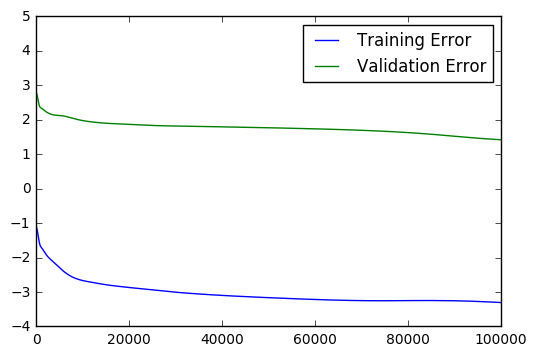

In [104]:
n.plot_error()

## Test the classification data against the provided output file

In [105]:
n.test(C, CZ)

'100.0%'

## Plot the decision boundary

This takes a while as a mesh of datapoints and their classification is plotted in the background

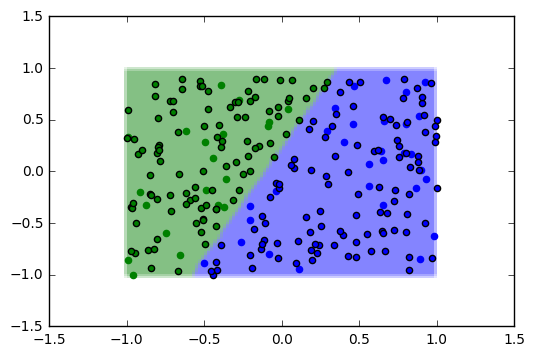

In [106]:
plt.figure()
a, b = n.get_boundary()
for i, cb in enumerate(b):
    if(cb[0] > 0):
        plt.scatter(a.T[0, i], a.T[1, i], color="green", alpha=0.1, edgecolors='none', marker='s')
    else:
        plt.scatter(a.T[0, i], a.T[1, i], color="blue", alpha=0.1, edgecolors='none', marker='s')
    
for i, z in enumerate(CZ):
    if z[0] > 0:
        plt.scatter(C.T[0, i], C.T[1, i], color="green")
    else:
        plt.scatter(C.T[0, i], C.T[1, i], color="blue")
        
for i, z in enumerate(Z):
    if z[0] > 0:
        plt.scatter(X.T[0, i], X.T[1, i], color="green", edgecolors="black")
    else:
        plt.scatter(X.T[0, i], X.T[1, i], color="blue", edgecolors="black")